In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
import os

image_dir = 'fulldataset'

def display_sample_image(emotion):
    
    image_filename = f"{emotion}.jpg" 
    image_path = os.path.join(image_dir, image_filename)

    # Check if the image exists
    if os.path.exists(image_path):
        # Open the image
        image = Image.open(imageS_path)
        
        # Display the image
        plt.imshow(image)
        plt.axis('off')  
        plt.title(emotion)  
        plt.show()
    else:
        print(f"Image for {emotion} not found.")

emotions = ["EXCITED", "NEUTRAL", "ANGRY", "HAPPY", "SAD", "FEAR", "DISGUST", "NOT_INTERESTED"]
# for emotion in emotions:
#     display_sample_image(emotion)
# display_sample_image("SAD")

In [2]:
from transformers import ViTFeatureExtractor
from PIL import Image
import os

# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("trpakov/vit-face-expression")

# Directory where your images are stored
image_dir = "fulldataset"

# Prepare a list of image paths and labels
image_paths = []
labels = []
emotions = ['ANGRY', 'EXCITED', 'FEAR', 'HAPPY', 'NEUTRAL', 'NOT_INTERESTED', 'SAD']

for emotion in emotions:
    for filename in os.listdir(image_dir):
        if emotion.lower() in filename.lower():
            image_paths.append(os.path.join(image_dir, filename))
            labels.append(emotion)

# Preprocess each image
inputs = []
for image_path in image_paths:
    image = Image.open(image_path)
    inputs.append(feature_extractor(images=image, return_tensors="pt"))


C:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\meena\AppData\Roaming\Python\Python312\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [12]:
from transformers import ViTForImageClassification, Trainer, TrainingArguments
import torch

# Define emotion labels (e.g., from your dataset)
emotions = ["ANGRY", "EXCITED", "FEAR", "HAPPY", "NEUTRAL", "NOT_INTERESTED", "SAD"]

# Load the model
model = ViTForImageClassification.from_pretrained("trpakov/vit-face-expression", num_labels=len(emotions))

# Prepare training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # Evaluate after every epoch
    save_strategy="epoch",  # Save after every epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    save_total_limit=2,  # Keep only the last 2 checkpoints
    logging_dir='./logs',
    logging_steps=10,  # Log every 50 steps
    load_best_model_at_end=True,  # Load best model at end of training
    report_to="none",  # Disable reporting to external services like Tensorboard for simplicity
)

# Custom Dataset for loading the preprocessed images and labels
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return {
            'pixel_values': self.inputs[idx]['pixel_values'][0],  # Get pixel values
            'labels': torch.tensor(emotions.index(self.labels[idx]))  # Convert label to tensor
        }

# Convert inputs and labels to PyTorch dataset
train_dataset = CustomDataset(inputs, labels)

# Fine-tuning the model using Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,  # For simplicity, using the same data for eval, split in real cases
)

# Start training
train_output = trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_vit_emotion")  # Saves the model, tokenizer, config

# Print the train output
print("Training Completed!")



C:\Users\meena\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,2.578851
2,No log,1.805989
3,No log,1.107596
4,2.554300,0.747785
5,2.554300,0.521592
6,2.554300,0.360422
7,0.587200,0.238783
8,0.587200,0.162984
9,0.587200,0.129041
10,0.190000,0.073664


Training Completed!


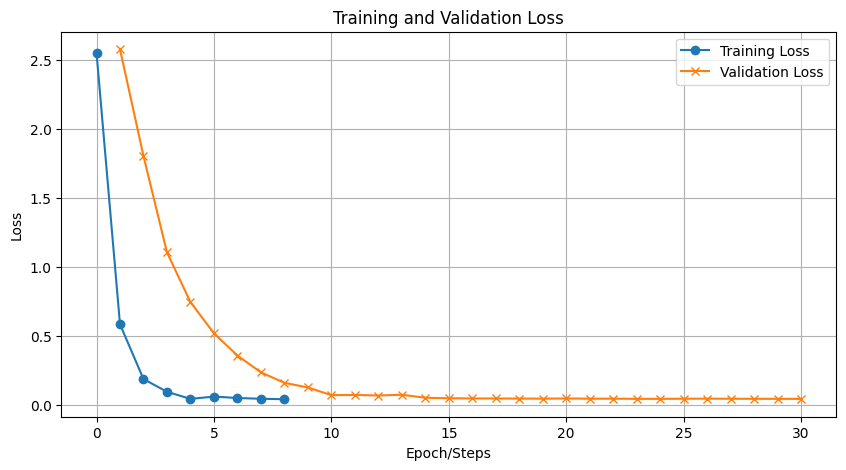

In [13]:
import matplotlib.pyplot as plt

# Extract log history from Trainer
log_history = trainer.state.log_history  # Automatically tracks both training and eval metrics

# Extract training and evaluation loss
train_loss = [entry["loss"] for entry in log_history if "loss" in entry]  # Training loss per log step
eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
epochs = list(range(1, len(eval_loss) + 1))  # Assuming eval occurs per epoch

# Plot Training and Evaluation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(epochs, eval_loss, label='Validation Loss', marker='x')
plt.xlabel('Epoch/Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


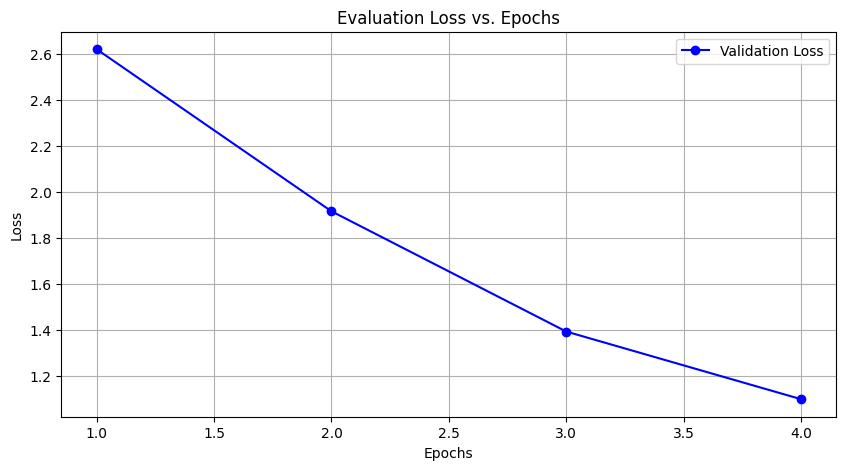

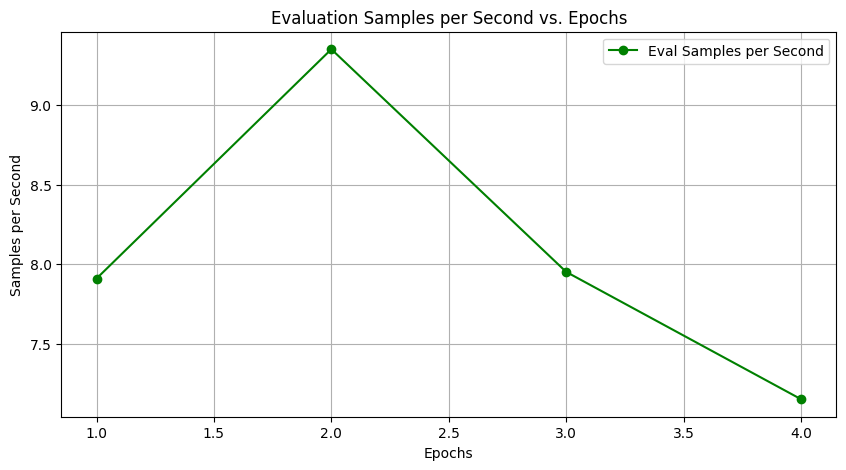

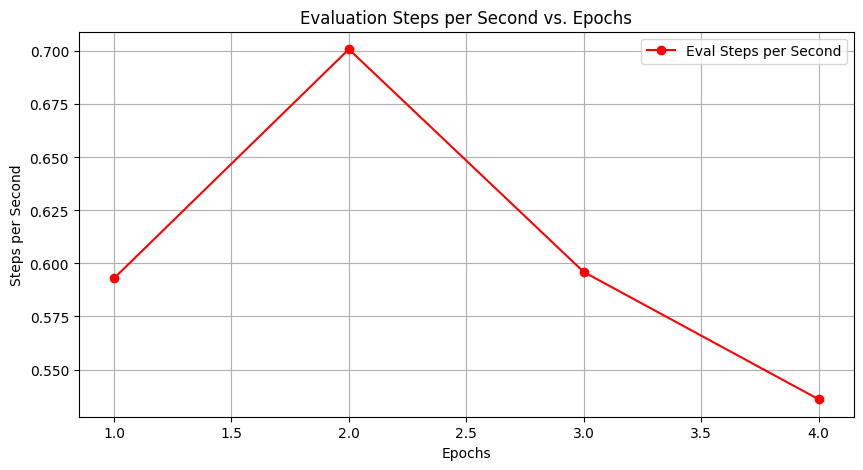

In [14]:
import matplotlib.pyplot as plt

# Data from trainer_state.json
log_history = [
    {"epoch": 1.0, "eval_loss": 2.6202244758605957, "eval_runtime": 5.0568, 
     "eval_samples_per_second": 7.91, "eval_steps_per_second": 0.593},
    {"epoch": 2.0, "eval_loss": 1.9159212112426758, "eval_runtime": 4.2769, 
     "eval_samples_per_second": 9.353, "eval_steps_per_second": 0.701},
    {"epoch": 3.0, "eval_loss": 1.3932371139526367, "eval_runtime": 5.0301, 
     "eval_samples_per_second": 7.952, "eval_steps_per_second": 0.596},
    {"epoch": 4.0, "eval_loss": 1.0992724895477295, "eval_runtime": 5.5934, 
     "eval_samples_per_second": 7.151, "eval_steps_per_second": 0.536}
]

# Extract data for plotting
epochs = [entry["epoch"] for entry in log_history]
eval_loss = [entry["eval_loss"] for entry in log_history]
eval_samples_per_second = [entry["eval_samples_per_second"] for entry in log_history]
eval_steps_per_second = [entry["eval_steps_per_second"] for entry in log_history]

# Plot Evaluation Loss vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_loss, marker='o', linestyle='-', color='b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evaluation Loss vs. Epochs')
plt.grid(True)
plt.legend()
plt.show()

# Plot Eval Samples per Second vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_samples_per_second, marker='o', linestyle='-', color='g', label='Eval Samples per Second')
plt.xlabel('Epochs')
plt.ylabel('Samples per Second')
plt.title('Evaluation Samples per Second vs. Epochs')
plt.grid(True)
plt.legend()
plt.show()

# Plot Eval Steps per Second vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_steps_per_second, marker='o', linestyle='-', color='r', label='Eval Steps per Second')
plt.xlabel('Epochs')
plt.ylabel('Steps per Second')
plt.title('Evaluation Steps per Second vs. Epochs')
plt.grid(True)
plt.legend()
plt.show()


In [15]:
import pandas as pd

# Metrics from training output
metrics = {
    "Metric": [
        "Global Steps",
        "Training Loss",
        "Training Runtime (s)",
        "Samples per Second",
        "Steps per Second",
        "Total FLOPs",
        "Epochs"
    ],
    "Value": [
        train_output.global_step,
        train_output.training_loss,
        train_output.metrics['train_runtime'],
        train_output.metrics['train_samples_per_second'],
        train_output.metrics['train_steps_per_second'],
        train_output.metrics['total_flos'],
        train_output.metrics['epoch']
    ]
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
print(metrics_df)


                 Metric         Value
0          Global Steps  9.000000e+01
1         Training Loss  4.093246e-01
2  Training Runtime (s)  7.416769e+02
3    Samples per Second  1.618000e+00
4      Steps per Second  1.210000e-01
5           Total FLOPs  9.299455e+16
6                Epochs  3.000000e+01


In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch

# Predict on the evaluation set
preds = trainer.predict(train_dataset)

# Convert predictions to tensor and get the predicted classes
predictions = torch.argmax(torch.tensor(preds.predictions), dim=-1)  # Convert to tensor
labels = preds.label_ids

# Accuracy
accuracy = accuracy_score(labels, predictions.numpy())  # Convert predictions back to NumPy for sklearn
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1
precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions.numpy(), average='weighted')  # Convert to NumPy
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")



Accuracy: 0.9750
Precision: 0.9786, Recall: 0.9750, F1-Score: 0.9746


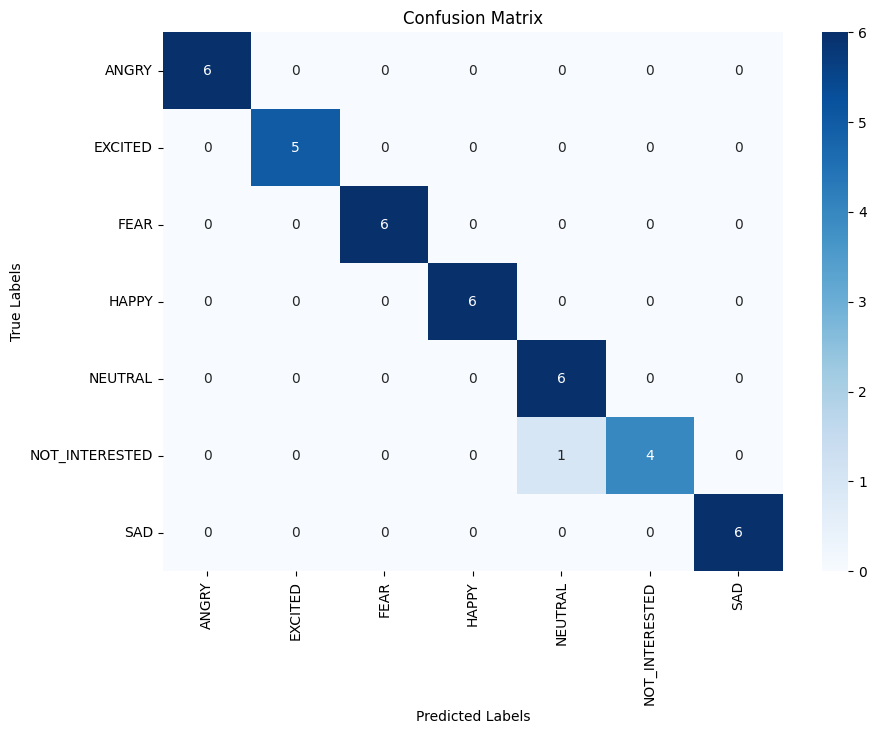

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, predictions.numpy())

# Define labels for the confusion matrix
emotion_labels = ["ANGRY", "EXCITED", "FEAR", "HAPPY", "NEUTRAL", "NOT_INTERESTED", "SAD"]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=emotion_labels, yticklabels=emotion_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [19]:
import cv2
from transformers import ViTForImageClassification, ViTImageProcessor
import torch
from PIL import Image

# Define emotion labels
emotions = ["ANGRY", "EXCITED", "FEAR", "HAPPY", "NEUTRAL", "NOT_INTERESTED", "SAD"]

# Load the fine-tuned model and feature extractor
model = ViTForImageClassification.from_pretrained("./fine_tuned_vit_emotion")
feature_extractor = ViTImageProcessor.from_pretrained("trpakov/vit-face-expression")
model.eval()

# Load the face detection model (using OpenCV's Haar Cascade for simplicity)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize camera
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=6, minSize=(50, 50))

    # Process each detected face
    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
        # Extract the face region of interest (ROI)
        face = frame[y:y + h, x:x + w]
        
        # Convert the face to a PIL image
        face_pil = Image.fromarray(face)
        
        # Preprocess the face for the ViT model
        inputs = feature_extractor(images=face_pil, return_tensors="pt")
        
        # Predict the emotion for the face
        with torch.no_grad():
            outputs = model(**inputs)
            predicted_class_idx = outputs.logits.argmax(-1).item()
            emotion = emotions[predicted_class_idx]
        
        # Annotate the frame with the detected emotion
        cv2.putText(frame, f'Emotion: {emotion}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Emotion Detection', frame)
    
    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close windows
cap.release()
cv2.destroyAllWindows()
